## Assessing allelic bias in RADseq data

Can we identify 'bad' loci by looking at allelic bias in heterozygotes?

Within a *heterozygous* individual we can assess allelic bias at a specific locus with a binomial test.  The null hypothesis is that each allelic sequence is equally likely. The p value represents the likelihood of a bias at least as big as observed under the null. Notice this is a two-tailed test.

In [1]:
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import numpy as np
import os.path
import gzip

In [2]:
%matplotlib inline

## Example bionimial test

In [3]:
coverage_allele_a = 10
coverage_allele_b = 30

p_value = scipy.stats.binom_test((coverage_allele_a,coverage_allele_b))
print(p_value)

0.00222143377323


Caveat: due to PCR duplicates the reads may not be **truly** independent, hopefully this effect is not allele-specific.

### Assessing one locus across multiple individuals

By observing allele bias at a target locus across multiple individuals we can try to see if there is a **consistent** bias.  

This raises the question of how to combine data from many individuals, I see two distinct options:
   1. weight each **allele observation** equally, essentially ignoring the indidviual that they appear in.  This implicitly assumes that any process generating bias operates somewhat cosistently across individuals.
   2. weight each **individual** equally, this accounts for the difference in coverage across individuals, ignoring the fact that individuals with difference coverages provide more information on allelic bias.
   
   OR 
   3. some combination the two.

#### In case 1. we can simply add up all the observations of the 'a' alelle and all observations of the 'b' allele and run the same binomial test.

In [4]:
coverage_allele_a_accross_individuals = (25,13,2,3,7,17,9,29,51,2,4,29,14)
coverage_allele_a = sum(coverage_allele_a_accross_individuals)
print('coverage_allele_a: {}'.format(coverage_allele_a))

coverage_allele_b_accross_individuals = (28,23,22,1,17,14,19,5,27,12,8,21,19)
coverage_allele_b = sum(coverage_allele_b_accross_individuals)
print('coverage_allele_a: {}'.format(coverage_allele_b))

p_value = scipy.stats.binom_test((coverage_allele_a,coverage_allele_b))
print(p_value)

coverage_allele_a: 205
coverage_allele_a: 216
0.626048377669


#### In case 2. we keep each individual separate.

In [5]:
ab = zip(coverage_allele_a_accross_individuals, coverage_allele_b_accross_individuals)
p_vals = [scipy.stats.binom_test(xx) for xx in ab]
p_vals

[0.78384630220949836,
 0.13249816396273675,
 3.5881996154785156e-05,
 0.625,
 0.063914656639099121,
 0.72010013181716115,
 0.087158553302288042,
 3.8558151572942747e-05,
 0.0087717144570601362,
 0.012939453124999998,
 0.38769531250000011,
 0.32223632035754712,
 0.4868502416647969]

combine the p values into one measure

Fisher's method

In [6]:
fisher_statistic, fisher_pval = scipy.stats.combine_pvalues(p_vals, method = 'fisher')
fisher_statistic, fisher_pval

(81.070899768715066, 1.4321730977438808e-07)

Stouffer's method.



In [7]:
stouffer_statistic, stouffer_pval = scipy.stats.combine_pvalues(p_vals, method = 'stouffer', weights = None) # can be weighted
stouffer_statistic, stouffer_pval

(4.3308924674047935, 7.4253098511083297e-06)

In this method you can weight the individuals.

In [8]:
my_weights = [np.sqrt(sum([a,b])) for a,b in ab]
stouffer_statistic, stouffer_pval = scipy.stats.combine_pvalues(p_vals, method = 'stouffer', weights = my_weights) # can be weighted
stouffer_statistic, stouffer_pval

(4.2883981531672024, 8.9983142308648029e-06)

### Create file of allelic depths

In [9]:
def write_allele_bias_file2(vcf_file, out_file):
    with gzip.open(vcf_file) as INFILE:
        with open(out_file, 'w') as OUTFILE:
            for line in INFILE:
                if line.startswith('##'):
                    print 'skipped!'
                    pass
                elif line.startswith('#CHROM'):
                    header = line.strip().strip('#').split('\t')
                    inds = header[9:]
                    #print(inds)
                else:
                    tabs = line.split('\t')
                    contig = tabs[0]
                    pos = tabs[1]
                    locus_ID = tabs[2]
                    genotypes = tabs[9:]
                    depth_a_of_ind = dict()
                    depth_b_of_ind = dict()
                    for gen_idx, gen in enumerate(genotypes):
                        if gen.split(':')[0] in ['1/0', '0/1']: # if het
                            depth_a_of_ind[inds[gen_idx]] = int(gen.split(':')[2].split(',')[0])
                            depth_b_of_ind[inds[gen_idx]] = int(gen.split(':')[2].split(',')[1])
                    sum_a = sum(depth_a_of_ind.values())
                    sum_b = sum(depth_b_of_ind.values())
                    num_hets = len(depth_b_of_ind.values())
                    if sum_a+sum_b > 0:
                        OUTFILE.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(contig, pos, locus_ID, sum_a, sum_b, np.float(sum_a)/(sum_a+sum_b), num_hets))

In [10]:
vcf_file = os.path.join('..', 'data', 'chinook.batch10.singleSNP.vcf.gz')
depths_file = os.path.join('..', 'data', 'chinook.batch10.singleSNP.depths')

In [11]:
write_allele_bias_file2(vcf_file=vcf_file, out_file = depths_file)

skipped!
skipped!
skipped!
skipped!
skipped!
skipped!
skipped!
skipped!
skipped!


In [12]:
depths = pd.read_csv(depths_file, sep = '\t', header = None)
depths.columns = ['contgis', 'pos', 'locus_ID', 'depth_a' , 'depth_b', 'ratio', 'num_hets']
depths.head()

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets
0,un,161,11,177,177,0.500000,9
1,un,207,14,91,81,0.529070,6
2,un,353,15,5138,7968,0.392034,198
3,un,451,17,274,285,0.490161,33
4,un,565,20,930,943,0.496530,43


In [13]:
depths['total_depth'] = depths['depth_a'] + depths['depth_b']
depths['depth_per_het'] = depths['total_depth']/[np.float(xx) for xx in depths['num_hets']]
depths.head()

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het
0,un,161,11,177,177,0.500000,9,354,39.333333
1,un,207,14,91,81,0.529070,6,172,28.666667
2,un,353,15,5138,7968,0.392034,198,13106,66.191919
3,un,451,17,274,285,0.490161,33,559,16.939394
4,un,565,20,930,943,0.496530,43,1873,43.558140


### Read in file of giving duplicate status (based on map):
   - 0 = unknown
   - 1 = non-duplicated
   - 2 = duplicated

In [14]:
duplicate_status = pd.read_csv(os.path.join('..', 'data', 'chinook_DuplicateStatus.txt'), sep = '\t', header = 0)
duplicate_status.columns = ['locus_ID', 'Duplicate']
duplicate_status.head()

,locus_ID,Duplicate
0,85492,0
1,60449,0
2,44557,0
3,23753,1
4,11439,0


In [15]:
depths = pd.merge(depths, duplicate_status)

In [16]:
depths.head()

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate
0,un,161,11,177,177,0.500000,9,354,39.333333,0
1,un,207,14,91,81,0.529070,6,172,28.666667,1
2,un,353,15,5138,7968,0.392034,198,13106,66.191919,2
3,un,451,17,274,285,0.490161,33,559,16.939394,0
4,un,565,20,930,943,0.496530,43,1873,43.558140,1


## Subset the loci based on various filters

In [17]:
filter_sets = pd.read_csv(os.path.join('..', 'data', 'chinook_FilteredLoci.txt'), '\t', header = 0)

filter_sets.head()

,locus_ID,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters
0,85492,1,1,0,0,0,0,0
1,60449,1,1,1,0,0,0,0
2,44557,1,1,1,1,0,1,0
3,23753,1,1,1,0,0,0,0
4,11439,1,1,1,0,1,0,0


In [18]:
depths = pd.merge(depths, filter_sets)

In [19]:
depths.head()

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters
0,un,161,11,177,177,0.500000,9,354,39.333333,0,1,1,1,1,0,1,0
1,un,207,14,91,81,0.529070,6,172,28.666667,1,1,1,1,1,1,1,1
2,un,353,15,5138,7968,0.392034,198,13106,66.191919,2,0,0,0,1,1,0,0
3,un,451,17,274,285,0.490161,33,559,16.939394,0,1,1,1,1,1,1,1
4,un,565,20,930,943,0.496530,43,1873,43.558140,1,1,1,1,1,1,1,1


#### calculated the expected std deviation, based on the binomial distribution

In [20]:
depths['std'] = scipy.stats.binom(n = depths['total_depth'], p = .5).std()
depths.head()

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std
0,un,161,11,177,177,0.500000,9,354,39.333333,0,1,1,1,1,0,1,0,9.407444
1,un,207,14,91,81,0.529070,6,172,28.666667,1,1,1,1,1,1,1,1,6.557439
2,un,353,15,5138,7968,0.392034,198,13106,66.191919,2,0,0,0,1,1,0,0,57.240720
3,un,451,17,274,285,0.490161,33,559,16.939394,0,1,1,1,1,1,1,1,11.821590
4,un,565,20,930,943,0.496530,43,1873,43.558140,1,1,1,1,1,1,1,1,21.639085


#### Z-score based on that std deviation

In [21]:
depths['z'] = -(depths['total_depth']/2. - depths['depth_a'])/ depths['std']
depths.head()

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std,z
0,un,161,11,177,177,0.500000,9,354,39.333333,0,1,1,1,1,0,1,0,9.407444,-0.000000
1,un,207,14,91,81,0.529070,6,172,28.666667,1,1,1,1,1,1,1,1,6.557439,0.762493
2,un,353,15,5138,7968,0.392034,198,13106,66.191919,2,0,0,0,1,1,0,0,57.240720,-24.720164
3,un,451,17,274,285,0.490161,33,559,16.939394,0,1,1,1,1,1,1,1,11.821590,-0.465250
4,un,565,20,930,943,0.496530,43,1873,43.558140,1,1,1,1,1,1,1,1,21.639085,-0.300382


Fraction of 'a' alleles

In [22]:
sum_a = sum(depths['depth_a'])
sum_b = sum(depths['depth_b'])
frac_a = np.float(sum_a)/(sum_a + sum_b)
print sum_a, sum_b, frac_a

27601783 24616071 0.528588995634


Highly significant!

In [23]:
p_value = scipy.stats.binom_test((sum_a, sum_b))
print(p_value)

2.32210853545e-322


In [24]:
from IPython.core.pylabtools import figsize
figsize(7,7)

## Remove some high-coverage loci

In [25]:
depths = depths[depths['total_depth'] < 100000]

## TODO: Merge/compare with filtered data

Absolute allele count difference

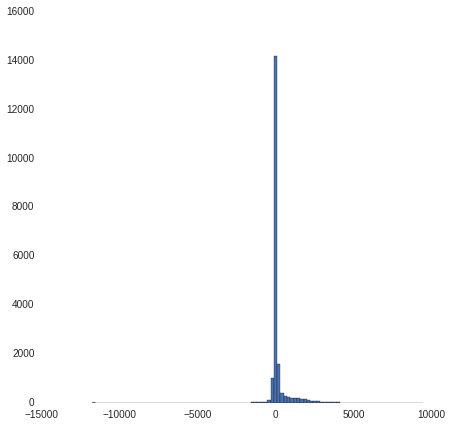

In [26]:
plt.hist(depths['depth_a']-depths['depth_b'], bins = 100)
plt.show()

Allelelic ratios

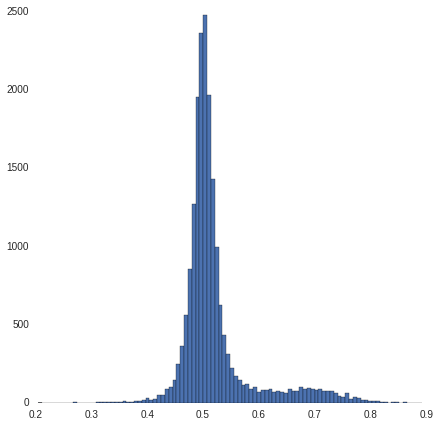

In [27]:
plt.hist(depths['ratio'], bins = 100)
plt.show()

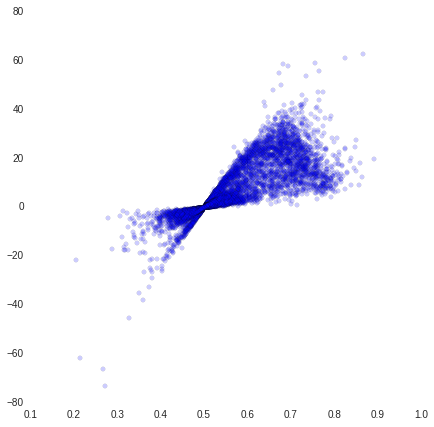

In [28]:
plt.scatter(depths['ratio'], depths['z'], alpha = .2)
plt.show()

histogram of z-scores

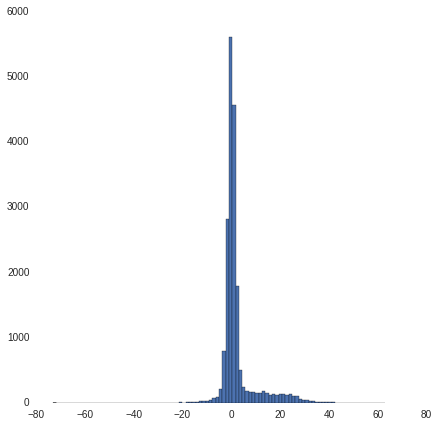

In [29]:
plt.hist(depths['z'], bins = 100)
plt.show()

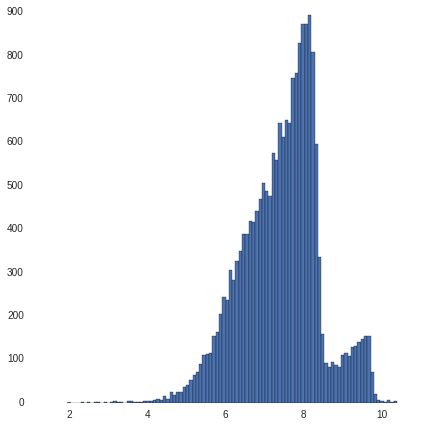

In [30]:
plt.hist(np.log(depths['total_depth']), bins = 100)
plt.show()

Higher depths leads to somewhat more bias

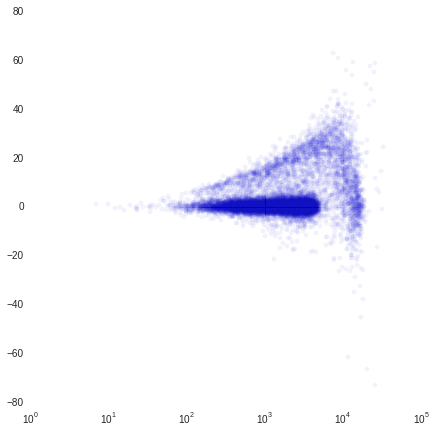

In [31]:
plt.scatter(depths['total_depth'], depths['z'], alpha = .05)
plt.xscale('log')
plt.show()

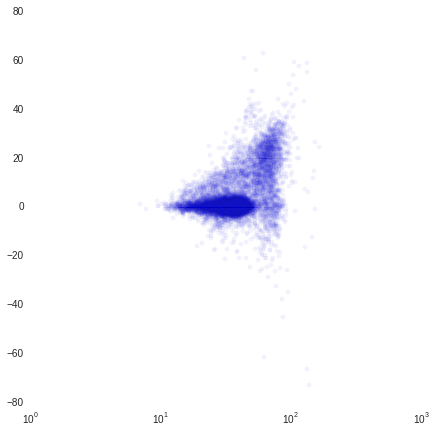

In [32]:
plt.scatter(depths['depth_per_het'], depths['z'], alpha = .05)
plt.xscale('log')
plt.show()

In [33]:
non_dups = depths[depths['Duplicate']==1]
dups = depths[depths['Duplicate']==2]
unk = depths[depths['Duplicate']==0]

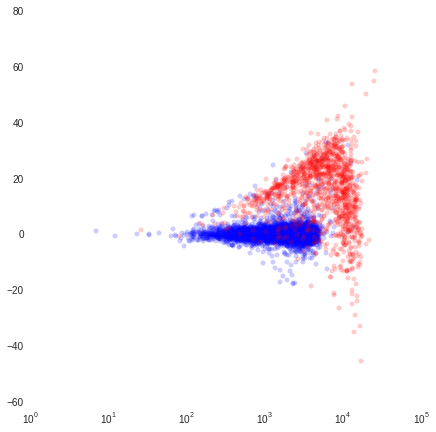

In [34]:
plt.scatter(non_dups['total_depth'], non_dups['z'], alpha = .2, color = 'blue')
plt.scatter(dups['total_depth'], dups['z'], alpha = .2, color = 'red')
#plt.scatter(unk['total_depth'], unk['z'], alpha = .05, color = 'green')
plt.xscale('log')
plt.show()

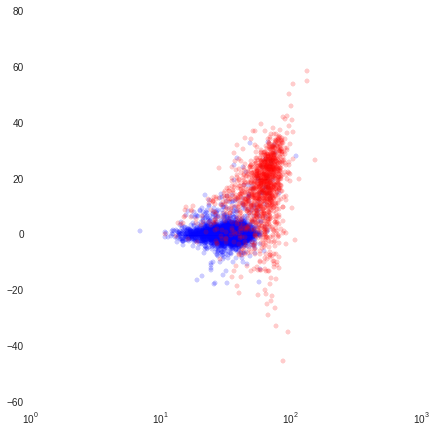

In [35]:
plt.scatter(non_dups['depth_per_het'], non_dups['z'], alpha = .2, color = 'blue')
plt.scatter(dups['depth_per_het'], dups['z'], alpha = .2, color = 'red')
#plt.scatter(unk['total_depth'], unk['z'], alpha = .05, color = 'green')
plt.xscale('log')
plt.show()

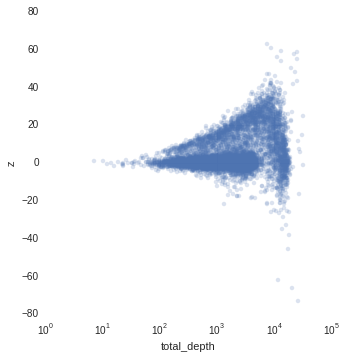

In [36]:
sns.lmplot(x = 'total_depth', y = 'z', data = depths, fit_reg = False, scatter_kws = {'alpha':0.2})
plt.xscale('log')
plt.show()

In [37]:
depths.head(1)

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std,z
0,un,161,11,177,177,0.5,9,354,39.333333,0,1,1,1,1,0,1,0,9.407444,-0


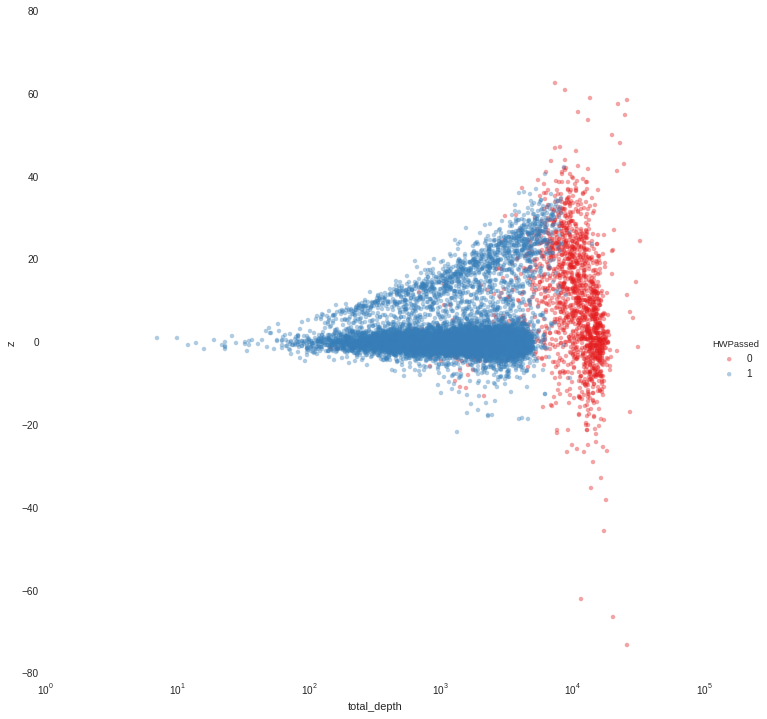

In [38]:
figsize(8,8)
sns.lmplot(x = 'total_depth', y = 'z', data = depths, fit_reg = False, hue = 'HWPassed', 
           palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.4}, size =10)
plt.xscale('log')

plt.show()

In [39]:
depths.head(1)

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std,z
0,un,161,11,177,177,0.5,9,354,39.333333,0,1,1,1,1,0,1,0,9.407444,-0


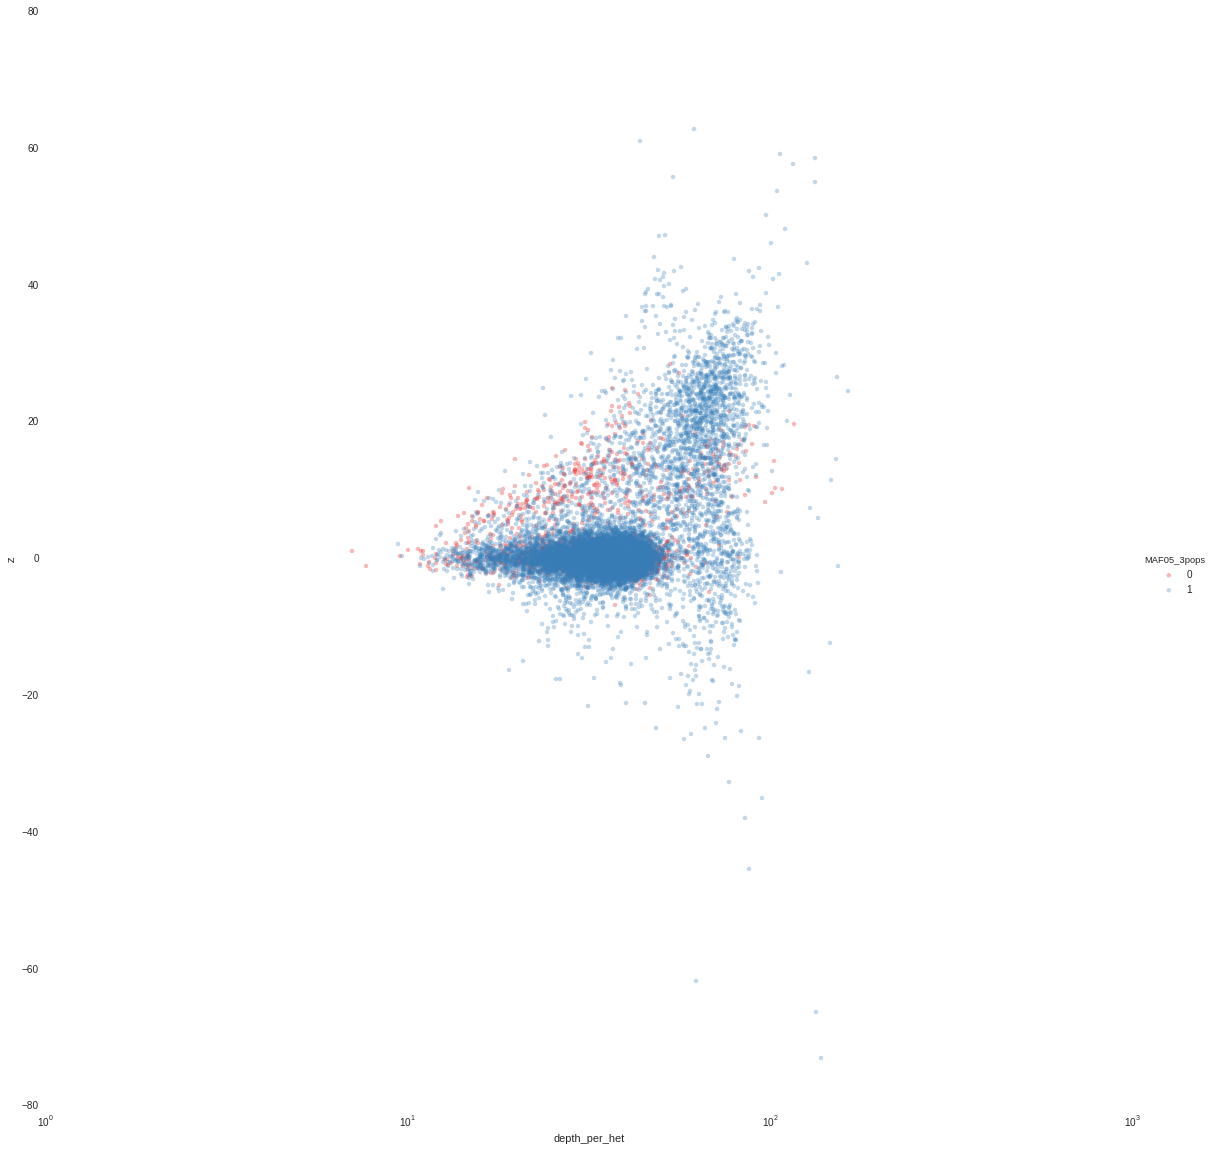

In [40]:
figsize(8,8)
sns.lmplot(x = 'depth_per_het', y = 'z', data = depths, fit_reg = False, hue = 'MAF05_3pops', 
           palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.3}, size =16)
plt.xscale('log')

plt.show()

No clear pattern of depth by position, maybe a slight trend down near the end of the reads.

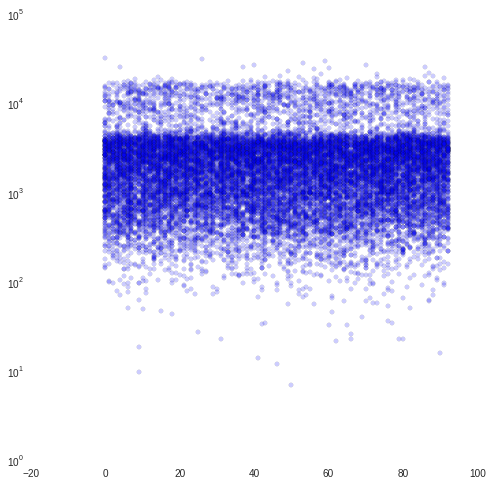

In [41]:
plt.scatter(depths['pos']%93, depths['total_depth'], alpha = .2)
plt.yscale('log')
plt.show()

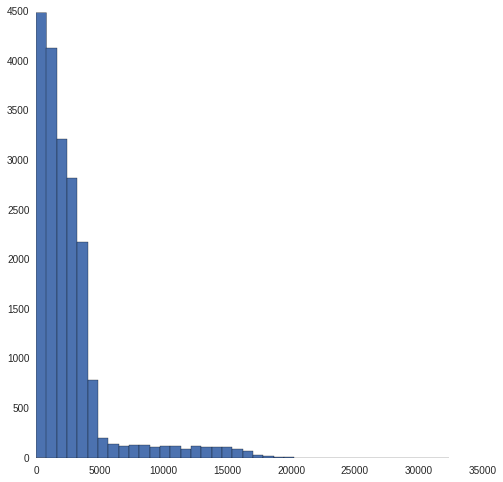

In [42]:
plt.hist(depths['total_depth'], bins = 40)
plt.show()

How is the z-score related to the allelic ratio?

Bias by position

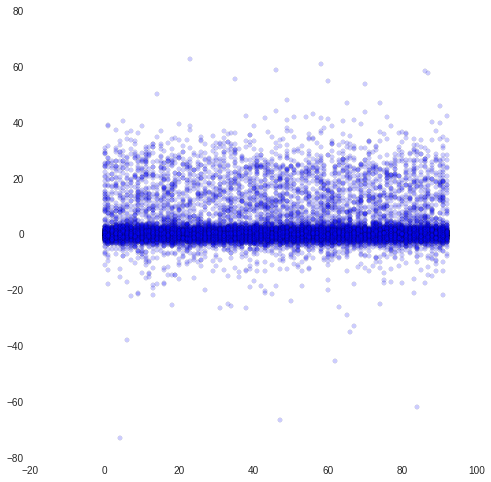

In [43]:
plt.scatter(depths['pos']%93, depths['z'], alpha = .2)
plt.show()

Relation to depth

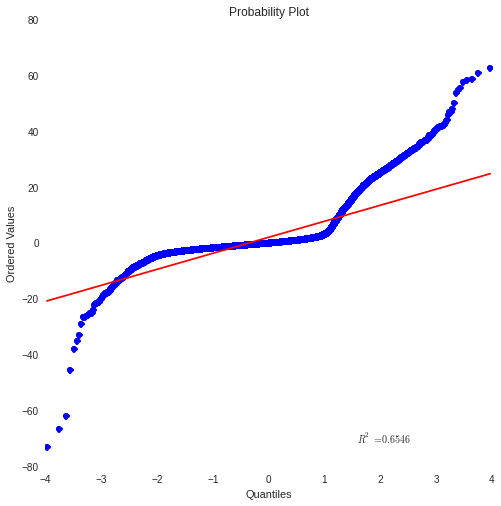

In [44]:
scipy.stats.probplot(depths['z'], dist="norm", plot=plt)
plt.show()

(-5, 5)

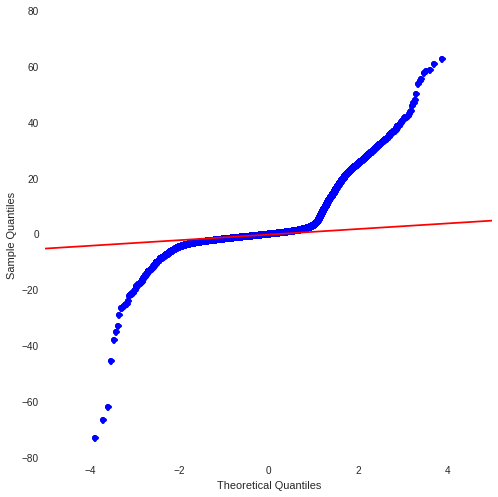

In [45]:
qq = statsmodels.graphics.gofplots.qqplot(depths['z'], line = '45')
plt.xlim(-5,5)

# BELOW IN PROGRESS

#### This will write out depth per locus per individual

In [46]:
def write_allele_bias_file_by_ind(vcf_file, out_file):
    with open(vcf_file) as INFILE:
        with open(out_file, 'w') as OUTFILE:
            for line in INFILE:
                if line.startswith('##'):
                    print 'skipped!'
                    pass
                elif line.startswith('#CHROM'):
                    header = line.strip().strip('#').split('\t')
                    inds = header[9:]
                    #print(inds)
                else:
                    tabs = line.split('\t')
                    contig = tabs[0]
                    pos = tabs[1]
                    genotypes = tabs[9:]
                    depth_a_of_ind = dict()
                    depth_b_of_ind = dict()
                    for gen_idx, gen in enumerate(genotypes):
                        if gen.split(':')[0] in ['1/0', '0/1']: # if het
                            depth_a = int(gen.split(':')[2].split(',')[0])
                            depth_b = int(gen.split(':')[2].split(',')[1])
                            std = scipy.stats.binom(n = depth_a + depth_b, p = .5).std()
                            z = ((depth_a + depth_b)/2. - depth_a)/ -std          
                            OUTFILE.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(
                                    contig, pos, inds[gen_idx], depth_a, depth_b, std, z))

In [47]:
#write_allele_bias_file_by_ind(vcf_file='/home/ipseg/Desktop/waples/temp/batch_10_singleSNP.vcf', out_file = '/home/ipseg/Desktop/waples/temp/batch_10_singleSNP.depths_by_ind')